In [2]:
library(DESeq2)
library(data.table)
library(dplyr)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
library(AnnotationDbi)
library(org.Hs.eg.db)
library(ggplot2)
library(gridExtra)
library(RColorBrewer)
library(IRdisplay)
library(IRdisplay)
library(ggpubr)
library(tidyverse)
library(readxl)
library(corrplot)
library(ggrepel)
library(ComplexHeatmap)
library(DT)
library(tools)
library(tidyverse)
library(RSQLite)
library(kableExtra)
library(ggraph)
library(tidygraph)
library(ggvenn)
library(ggVennDiagram)
library(tools)
library(DT)
library(ggraph)
library(edgeR)
library(sva)


In [3]:
source('/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/script/utils.r')
base_dir = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/SyedAhmad/AZA_treated_Patients_analysis'
setwd(base_dir)
data_dir = base_dir


In [4]:
add_ann = function(dat, n = NULL){
    if(!is.data.table(dat)){dat = as.data.table(dat, keep.rownames = T)}
    if(is.null(n)){n = length(unlist(strsplit(unname(unlist(dat[1,1])), ':')))}
    dat[, class_id := unlist(strsplit(rn, ':'))[n], by = 1:nrow(dat) ]
    dat[, family_id := unlist(strsplit(rn, ':'))[n-1], by = 1:nrow(dat) ]
    dat[, gene_id := unlist(strsplit(rn, ':'))[n-2], by = 1:nrow(dat) ]
    if(n == 4) { dat[, tx_id := unlist(strsplit(rn, ':'))[n-3], by = 1:nrow(dat) ] } 
    dat
}


In [5]:
dsn1 = read.csv(file = "Australian_cohort_metadata_summary.txt", header = TRUE, sep = "\t")
dsn2 = read.csv(file = "Nordic_cohort_cohort_metadata_summary_v3.txt", header = TRUE, sep = "\t")

head(dsn1)
head(dsn2)


,Patient_ID,Condition,Response_Group
,<chr>,<chr>,<chr>
1,PD7151,5-azacytidine,Responder
2,PD7151,Pre-treatment,Responder
3,PD7152,5-azacytidine,Non-Responder
4,PD7152,Pre-treatment,Non-Responder
5,PD7153,5-azacytidine,Responder
6,PD7153,Pre-treatment,Responder


,Patient_ID,Condition,Response_Group,Revised_Patient_Id
,<chr>,<chr>,<chr>,<chr>
1,1,5-azacytidine,Non-Responder,1_5-azacytidine
2,1,Pre-treatment,Non-Responder,1_Pre-treatment
3,131,5-azacytidine,Responder,131_5-azacytidine
4,131,Pre-treatment,Responder,131_Pre-treatment
5,1344,5-azacytidine,Non-Responder,1344_5-azacytidine
6,1344,Pre-treatment,Non-Responder,1344_Pre-treatment


In [6]:
dsn1 = dsn1[, 1:3]
dsn2 = dsn2[, 1:3]
dsn = rbind(dsn1, dsn2)
head(dsn)


,Patient_ID,Condition,Response_Group
,<chr>,<chr>,<chr>
1,PD7151,5-azacytidine,Responder
2,PD7151,Pre-treatment,Responder
3,PD7152,5-azacytidine,Non-Responder
4,PD7152,Pre-treatment,Non-Responder
5,PD7153,5-azacytidine,Responder
6,PD7153,Pre-treatment,Responder


In [7]:
# Add the "Batch" column based on the prefix of "Patient_ID"
dsn$Batch = ifelse(grepl("^PD", dsn$Patient_ID), "Australian", "Nordic")

# Renaming Prefix of all samples for consistent
dsn$Patient_ID = ifelse(dsn$Batch == "Nordic" & !grepl("^K", dsn$Patient_ID),
                         paste0("N", dsn$Patient_ID),
                         dsn$Patient_ID)

head(dsn)


,Patient_ID,Condition,Response_Group,Batch
,<chr>,<chr>,<chr>,<chr>
1,PD7151,5-azacytidine,Responder,Australian
2,PD7151,Pre-treatment,Responder,Australian
3,PD7152,5-azacytidine,Non-Responder,Australian
4,PD7152,Pre-treatment,Non-Responder,Australian
5,PD7153,5-azacytidine,Responder,Australian
6,PD7153,Pre-treatment,Responder,Australian


In [8]:
Nordic_count = read.csv(file = "Nordic_cohort_merged_count_data_patients_revised.txt", header = TRUE, sep = "\t")
colnames(Nordic_count) <- gsub("^X", "N", colnames(Nordic_count))

Australian_count = read.csv(file = "Australian_cohort_merged_count_data_patients.txt", header = TRUE, sep = "\t")
head(Australian_count)
head(Nordic_count)


,gene.TE,PD7151_5.azacytidine,PD7151_Pre.treatment,PD7152_5.azacytidine,PD7152_Pre.treatment,PD7153_5.azacytidine,PD7153_Pre.treatment,PD7155_5.azacytidine,PD7155_Pre.treatment,PD7156_5.azacytidine,⋯,PD7164_5.azacytidine,PD7164_Pre.treatment,PD7166_5.azacytidine,PD7166_Pre.treatment,PD7167_5.azacytidine,PD7167_Pre.treatment,PD7168_5.azacytidine,PD7168_Pre.treatment,PD7169_5.azacytidine,PD7169_Pre.treatment
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,(CATTC)n:Satellite:Satellite,134,0,0,0,0,0,9,5,35,⋯,0,0,2,4,0,0,1,0,0,5
2,(GAATG)n:Satellite:Satellite,137,3,0,2,2,1,16,11,40,⋯,3,4,7,5,2,4,1,3,2,10
3,7SLRNA:srpRNA:srpRNA,1,10,9,7,3,1,2,6,6,⋯,3,3,7,4,12,1,0,2,2,7
4,A-rich:Low_complexity:Low_complexity,0,2,0,0,0,0,0,0,0,⋯,0,0,3,0,0,0,0,0,0,1
5,A1BG,46,34,26,39,24,11,27,33,35,⋯,17,17,26,25,63,51,25,37,36,34
6,A1BG-AS1,28,36,3,23,22,23,10,48,58,⋯,20,23,47,27,84,60,36,52,39,55


,gene.TE,N1_5.azacytidine,N1_Pre.treatment,N131_5.azacytidine,N131_Pre.treatment,N1344_5.azacytidine,N1344_Pre.treatment,N141_5.azacytidine,N141_Pre.treatment,N213_5.azacytidine,⋯,N4_5.azacytidine,N4_Pre.treatment,N7_5.azacytidine,N7_Pre.treatment,N9_5.azacytidine,N9_Pre.treatment,K1_5.azacytidine,K1_Pre.treatment,K2_5.azacytidine,K2_Pre.treatment
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,(CATTC)n:Satellite:Satellite,71,13,6,3,12,4,12,2,1,⋯,12,3,28,8,5,3,42,10,6,1
2,(GAATG)n:Satellite:Satellite,194,59,24,12,135,35,47,8,79,⋯,192,75,63,14,43,13,69,23,89,14
3,7SLRNA:srpRNA:srpRNA,38,44,87,23,28,27,64,14,66,⋯,121,62,121,44,57,18,55,53,116,29
4,A-rich:Low_complexity:Low_complexity,36,11,10,3,4,6,12,3,16,⋯,26,1,16,6,9,2,131,10,19,7
5,A1BG,197,208,281,308,169,229,358,92,372,⋯,478,112,606,254,241,72,159,119,371,114
6,A1BG-AS1,94,106,252,112,124,194,340,71,265,⋯,326,49,385,191,87,52,141,139,280,81


In [9]:
# Merging the datasets
merged_count = cbind(Australian_count, Nordic_count[, -1])

head(merged_count)
tail(merged_count)


,gene.TE,PD7151_5.azacytidine,PD7151_Pre.treatment,PD7152_5.azacytidine,PD7152_Pre.treatment,PD7153_5.azacytidine,PD7153_Pre.treatment,PD7155_5.azacytidine,PD7155_Pre.treatment,PD7156_5.azacytidine,⋯,N4_5.azacytidine,N4_Pre.treatment,N7_5.azacytidine,N7_Pre.treatment,N9_5.azacytidine,N9_Pre.treatment,K1_5.azacytidine,K1_Pre.treatment,K2_5.azacytidine,K2_Pre.treatment
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,(CATTC)n:Satellite:Satellite,134,0,0,0,0,0,9,5,35,⋯,12,3,28,8,5,3,42,10,6,1
2,(GAATG)n:Satellite:Satellite,137,3,0,2,2,1,16,11,40,⋯,192,75,63,14,43,13,69,23,89,14
3,7SLRNA:srpRNA:srpRNA,1,10,9,7,3,1,2,6,6,⋯,121,62,121,44,57,18,55,53,116,29
4,A-rich:Low_complexity:Low_complexity,0,2,0,0,0,0,0,0,0,⋯,26,1,16,6,9,2,131,10,19,7
5,A1BG,46,34,26,39,24,11,27,33,35,⋯,478,112,606,254,241,72,159,119,371,114
6,A1BG-AS1,28,36,3,23,22,23,10,48,58,⋯,326,49,385,191,87,52,141,139,280,81


,gene.TE,PD7151_5.azacytidine,PD7151_Pre.treatment,PD7152_5.azacytidine,PD7152_Pre.treatment,PD7153_5.azacytidine,PD7153_Pre.treatment,PD7155_5.azacytidine,PD7155_Pre.treatment,PD7156_5.azacytidine,⋯,N4_5.azacytidine,N4_Pre.treatment,N7_5.azacytidine,N7_Pre.treatment,N9_5.azacytidine,N9_Pre.treatment,K1_5.azacytidine,K1_Pre.treatment,K2_5.azacytidine,K2_Pre.treatment
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
58819,hAT-N1_Mam:hAT-Tip100:DNA,59,167,315,65,63,31,65,40,53,⋯,1996,388,1968,886,1061,420,1007,702,1532,470
58820,hAT-N1_Mam:hAT-Tip100?:DNA,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0,0
58821,hAT-N1a_Mam:hAT-Tip100:DNA,101,265,195,106,101,101,120,78,107,⋯,5602,1865,3727,1709,2142,936,2088,1590,3582,908
58822,teucerv1_5edge:Unknown:Unknown,239,271,181,117,110,91,113,65,267,⋯,3076,305,10994,1490,9556,1709,5694,588,2346,328
58823,teucerv2_3edge:Unknown:Unknown,948,1132,870,633,668,547,625,490,995,⋯,1660,246,2305,832,1106,718,1280,589,1241,227
58824,teucerv3_internal:Unknown:Unknown,0,0,0,0,0,0,0,0,0,⋯,24,3,43,12,7,13,67,3,15,0


In [10]:
# Rename column headers consistent
colnames(merged_count) = gsub("5\\.azacytidine", "5-azacytidine", colnames(merged_count))
colnames(merged_count) = gsub("Pre\\.treatment", "Pre-treatment", colnames(merged_count))
head(merged_count)


,gene.TE,PD7151_5-azacytidine,PD7151_Pre-treatment,PD7152_5-azacytidine,PD7152_Pre-treatment,PD7153_5-azacytidine,PD7153_Pre-treatment,PD7155_5-azacytidine,PD7155_Pre-treatment,PD7156_5-azacytidine,⋯,N4_5-azacytidine,N4_Pre-treatment,N7_5-azacytidine,N7_Pre-treatment,N9_5-azacytidine,N9_Pre-treatment,K1_5-azacytidine,K1_Pre-treatment,K2_5-azacytidine,K2_Pre-treatment
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,(CATTC)n:Satellite:Satellite,134,0,0,0,0,0,9,5,35,⋯,12,3,28,8,5,3,42,10,6,1
2,(GAATG)n:Satellite:Satellite,137,3,0,2,2,1,16,11,40,⋯,192,75,63,14,43,13,69,23,89,14
3,7SLRNA:srpRNA:srpRNA,1,10,9,7,3,1,2,6,6,⋯,121,62,121,44,57,18,55,53,116,29
4,A-rich:Low_complexity:Low_complexity,0,2,0,0,0,0,0,0,0,⋯,26,1,16,6,9,2,131,10,19,7
5,A1BG,46,34,26,39,24,11,27,33,35,⋯,478,112,606,254,241,72,159,119,371,114
6,A1BG-AS1,28,36,3,23,22,23,10,48,58,⋯,326,49,385,191,87,52,141,139,280,81


In [11]:
# Merging Patient_ID and Condition 
dsn$Merged_ID_Condition = paste(dsn$Patient_ID, dsn$Condition, sep = "_")
head(dsn)


,Patient_ID,Condition,Response_Group,Batch,Merged_ID_Condition
,<chr>,<chr>,<chr>,<chr>,<chr>
1,PD7151,5-azacytidine,Responder,Australian,PD7151_5-azacytidine
2,PD7151,Pre-treatment,Responder,Australian,PD7151_Pre-treatment
3,PD7152,5-azacytidine,Non-Responder,Australian,PD7152_5-azacytidine
4,PD7152,Pre-treatment,Non-Responder,Australian,PD7152_Pre-treatment
5,PD7153,5-azacytidine,Responder,Australian,PD7153_5-azacytidine
6,PD7153,Pre-treatment,Responder,Australian,PD7153_Pre-treatment


In [12]:
cpm_fun = function(mtx_combat, dsn){
    dge = DGEList(counts=mtx_combat, group = dsn$Condition)
    dge = calcNormFactors(dge)
    dge = normLibSizes(dge)
    logcpm = cpm(dge, log = T)
    logcpm
}


In [13]:
mtx = merged_count
head(mtx)


,gene.TE,PD7151_5-azacytidine,PD7151_Pre-treatment,PD7152_5-azacytidine,PD7152_Pre-treatment,PD7153_5-azacytidine,PD7153_Pre-treatment,PD7155_5-azacytidine,PD7155_Pre-treatment,PD7156_5-azacytidine,⋯,N4_5-azacytidine,N4_Pre-treatment,N7_5-azacytidine,N7_Pre-treatment,N9_5-azacytidine,N9_Pre-treatment,K1_5-azacytidine,K1_Pre-treatment,K2_5-azacytidine,K2_Pre-treatment
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,(CATTC)n:Satellite:Satellite,134,0,0,0,0,0,9,5,35,⋯,12,3,28,8,5,3,42,10,6,1
2,(GAATG)n:Satellite:Satellite,137,3,0,2,2,1,16,11,40,⋯,192,75,63,14,43,13,69,23,89,14
3,7SLRNA:srpRNA:srpRNA,1,10,9,7,3,1,2,6,6,⋯,121,62,121,44,57,18,55,53,116,29
4,A-rich:Low_complexity:Low_complexity,0,2,0,0,0,0,0,0,0,⋯,26,1,16,6,9,2,131,10,19,7
5,A1BG,46,34,26,39,24,11,27,33,35,⋯,478,112,606,254,241,72,159,119,371,114
6,A1BG-AS1,28,36,3,23,22,23,10,48,58,⋯,326,49,385,191,87,52,141,139,280,81


In [14]:
dsn_df = setDF(dsn[, 2:ncol(dsn)], rownames = dsn$Merged_ID_Condition)

head(dsn_df)


,Condition,Response_Group,Batch,Merged_ID_Condition
,<chr>,<chr>,<chr>,<chr>
PD7151_5-azacytidine,5-azacytidine,Responder,Australian,PD7151_5-azacytidine
PD7151_Pre-treatment,Pre-treatment,Responder,Australian,PD7151_Pre-treatment
PD7152_5-azacytidine,5-azacytidine,Non-Responder,Australian,PD7152_5-azacytidine
PD7152_Pre-treatment,Pre-treatment,Non-Responder,Australian,PD7152_Pre-treatment
PD7153_5-azacytidine,5-azacytidine,Responder,Australian,PD7153_5-azacytidine
PD7153_Pre-treatment,Pre-treatment,Responder,Australian,PD7153_Pre-treatment


In [30]:
table(dsn_df$Batch)


Australian     Nordic 
        28         24 

In [15]:
batch = dsn_df$Batch
mtx = as.matrix(mtx[,-1])
mtx_combat = ComBat_seq(mtx, batch=batch, group=NULL)


Found 2 batches
Using null model in ComBat-seq.
Adjusting for 0 covariate(s) or covariate level(s)
Estimating dispersions
Fitting the GLM model
Shrinkage off - using GLM estimates for parameters
Adjusting the data


In [35]:
head(mtx)

PD7151_5-azacytidine,PD7151_Pre-treatment,PD7152_5-azacytidine,PD7152_Pre-treatment,PD7153_5-azacytidine,PD7153_Pre-treatment,PD7155_5-azacytidine,PD7155_Pre-treatment,PD7156_5-azacytidine,PD7156_Pre-treatment,⋯,N4_5-azacytidine,N4_Pre-treatment,N7_5-azacytidine,N7_Pre-treatment,N9_5-azacytidine,N9_Pre-treatment,K1_5-azacytidine,K1_Pre-treatment,K2_5-azacytidine,K2_Pre-treatment
134,0,0,0,0,0,9,5,35,1221,⋯,12,3,28,8,5,3,42,10,6,1
137,3,0,2,2,1,16,11,40,1494,⋯,192,75,63,14,43,13,69,23,89,14
1,10,9,7,3,1,2,6,6,1,⋯,121,62,121,44,57,18,55,53,116,29
0,2,0,0,0,0,0,0,0,0,⋯,26,1,16,6,9,2,131,10,19,7
46,34,26,39,24,11,27,33,35,19,⋯,478,112,606,254,241,72,159,119,371,114
28,36,3,23,22,23,10,48,58,26,⋯,326,49,385,191,87,52,141,139,280,81


In [33]:
cpm_fun

function(mtx_combat, dsn){
    dge = DGEList(counts=mtx_combat, group = dsn$Condition)
    dge = calcNormFactors(dge)
    dge = normLibSizes(dge)
    logcpm = cpm(dge, log = T)
    logcpm
}

In [34]:
head(mtx_combat)

PD7151_5-azacytidine,PD7151_Pre-treatment,PD7152_5-azacytidine,PD7152_Pre-treatment,PD7153_5-azacytidine,PD7153_Pre-treatment,PD7155_5-azacytidine,PD7155_Pre-treatment,PD7156_5-azacytidine,PD7156_Pre-treatment,⋯,N4_5-azacytidine,N4_Pre-treatment,N7_5-azacytidine,N7_Pre-treatment,N9_5-azacytidine,N9_Pre-treatment,K1_5-azacytidine,K1_Pre-treatment,K2_5-azacytidine,K2_Pre-treatment
23,0,0,0,0,0,5,4,11,113,⋯,2,1,64,8,1,1,1345,23,1,1
40,4,0,3,4,1,10,10,19,267,⋯,966,580,22,2,27,6,234,10,203,12
1,10,9,7,4,1,3,7,7,1,⋯,120,70,114,42,52,16,54,53,122,30
0,4,0,0,0,0,0,0,0,0,⋯,8,1,3,2,2,1,128,3,6,3
38,28,21,32,19,9,22,27,29,16,⋯,619,146,784,327,315,95,208,157,480,147
18,23,2,15,14,15,6,31,37,17,⋯,564,85,666,332,149,90,244,241,486,140


In [16]:
logcpm_mtx = cpm_fun(mtx_combat, dsn)
#logcpm_mtx = log(mtx_combat + 1)
#logcpm_mtx = log(mtx + 1)
#logcpm_mtx = mtx
head(logcpm_mtx)
nrow(merged_count)
nrow(logcpm_mtx)


library(data.table)
library(edgeR)
library(GGally)
library(ggplot2)

# Loading the data
#count_data = merged_count 
#meta_data <- dsn
#exon_lengths <- fread("Gene_TE_merged_v2.txt", sep = "\t")
#expr <- DGEList(counts=merged_count, group=meta_data$Response_Group)
#expr <- mtx
#rpkm_count = rpkm(expr, gene.length=exon_lengths$ExonLength)
#logcpm_mtx = log2(rpkm_count)


,PD7151_5-azacytidine,PD7151_Pre-treatment,PD7152_5-azacytidine,PD7152_Pre-treatment,PD7153_5-azacytidine,PD7153_Pre-treatment,PD7155_5-azacytidine,PD7155_Pre-treatment,PD7156_5-azacytidine,PD7156_Pre-treatment,⋯,N4_5-azacytidine,N4_Pre-treatment,N7_5-azacytidine,N7_Pre-treatment,N9_5-azacytidine,N9_Pre-treatment,K1_5-azacytidine,K1_Pre-treatment,K2_5-azacytidine,K2_Pre-treatment
1,2.380836,-4.1930971,-4.1930971,-4.1930971,-4.1930971,-4.193097,0.0996442,-0.70476358,0.69250905,4.408888,⋯,-3.83765298,-3.464170,-1.0386151,-2.4839100,-3.9243283,-3.620354,4.3555557,-1.19140597,-3.9594843,-3.4783591
2,3.172752,-0.6140222,-4.1930971,-0.9090030,-0.6862562,-2.293053,1.0623621,0.53789440,1.46030790,5.647262,⋯,2.89373156,4.385447,-2.2989350,-3.5446857,-1.4862263,-2.220737,1.8507074,-2.17604539,1.0039215,-1.0730403
3,-1.842983,0.6335947,1.1637668,0.2261753,-0.6862562,-2.293053,-0.5890649,0.04641774,0.06805455,-2.045884,⋯,-0.04231312,1.362056,-0.2785984,-0.5019798,-0.6510223,-1.055989,-0.1936584,-0.09278742,0.2952014,0.1457233
4,-4.193097,-0.6140222,-4.1930971,-4.1930971,-4.1930971,-4.193097,-4.1930971,-4.19309709,-4.19309709,-4.193097,⋯,-3.11072325,-3.464170,-3.7383861,-3.5446857,-3.6978538,-3.620354,0.9983394,-3.25630475,-3.1542016,-2.6453732
5,3.099211,2.0859636,2.3659008,2.3651564,1.4578266,0.484423,2.1791164,1.93623682,2.06044338,1.611045,⋯,2.25758484,2.406537,2.4190511,2.3580598,1.8404462,1.370616,1.6835133,1.41709087,2.2225994,2.3806138
6,2.031399,1.8062036,-0.8879226,1.2892935,1.0274724,1.198660,0.3503580,2.13288392,2.40782149,1.696988,⋯,2.12494815,1.636739,2.1863302,2.3797207,0.7847372,1.294307,1.9101835,2.02502814,2.2403127,2.3109816


[1] 58824

[1] 58824

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



In [17]:
#logcpm_df = as.data.frame(logcpm_mtx)
logcpm_df = as.data.frame(logcpm_mtx)
logcpm_df$gene.TE = merged_count$gene.TE
# Move 'gene.TE' to the first column
logcpm_df = logcpm_df[, c("gene.TE", setdiff(names(logcpm_df), "gene.TE"))]
head(logcpm_df)


,gene.TE,PD7151_5-azacytidine,PD7151_Pre-treatment,PD7152_5-azacytidine,PD7152_Pre-treatment,PD7153_5-azacytidine,PD7153_Pre-treatment,PD7155_5-azacytidine,PD7155_Pre-treatment,PD7156_5-azacytidine,⋯,N4_5-azacytidine,N4_Pre-treatment,N7_5-azacytidine,N7_Pre-treatment,N9_5-azacytidine,N9_Pre-treatment,K1_5-azacytidine,K1_Pre-treatment,K2_5-azacytidine,K2_Pre-treatment
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,(CATTC)n:Satellite:Satellite,2.380836,-4.1930971,-4.1930971,-4.1930971,-4.1930971,-4.193097,0.0996442,-0.70476358,0.69250905,⋯,-3.83765298,-3.464170,-1.0386151,-2.4839100,-3.9243283,-3.620354,4.3555557,-1.19140597,-3.9594843,-3.4783591
2,(GAATG)n:Satellite:Satellite,3.172752,-0.6140222,-4.1930971,-0.9090030,-0.6862562,-2.293053,1.0623621,0.53789440,1.46030790,⋯,2.89373156,4.385447,-2.2989350,-3.5446857,-1.4862263,-2.220737,1.8507074,-2.17604539,1.0039215,-1.0730403
3,7SLRNA:srpRNA:srpRNA,-1.842983,0.6335947,1.1637668,0.2261753,-0.6862562,-2.293053,-0.5890649,0.04641774,0.06805455,⋯,-0.04231312,1.362056,-0.2785984,-0.5019798,-0.6510223,-1.055989,-0.1936584,-0.09278742,0.2952014,0.1457233
4,A-rich:Low_complexity:Low_complexity,-4.193097,-0.6140222,-4.1930971,-4.1930971,-4.1930971,-4.193097,-4.1930971,-4.19309709,-4.19309709,⋯,-3.11072325,-3.464170,-3.7383861,-3.5446857,-3.6978538,-3.620354,0.9983394,-3.25630475,-3.1542016,-2.6453732
5,A1BG,3.099211,2.0859636,2.3659008,2.3651564,1.4578266,0.484423,2.1791164,1.93623682,2.06044338,⋯,2.25758484,2.406537,2.4190511,2.3580598,1.8404462,1.370616,1.6835133,1.41709087,2.2225994,2.3806138
6,A1BG-AS1,2.031399,1.8062036,-0.8879226,1.2892935,1.0274724,1.198660,0.3503580,2.13288392,2.40782149,⋯,2.12494815,1.636739,2.1863302,2.3797207,0.7847372,1.294307,1.9101835,2.02502814,2.2403127,2.3109816


In [18]:
library(data.table)
library(edgeR)
library(GGally)
library(ggplot2)
head(dsn_df)


,Condition,Response_Group,Batch,Merged_ID_Condition
,<chr>,<chr>,<chr>,<chr>
PD7151_5-azacytidine,5-azacytidine,Responder,Australian,PD7151_5-azacytidine
PD7151_Pre-treatment,Pre-treatment,Responder,Australian,PD7151_Pre-treatment
PD7152_5-azacytidine,5-azacytidine,Non-Responder,Australian,PD7152_5-azacytidine
PD7152_Pre-treatment,Pre-treatment,Non-Responder,Australian,PD7152_Pre-treatment
PD7153_5-azacytidine,5-azacytidine,Responder,Australian,PD7153_5-azacytidine
PD7153_Pre-treatment,Pre-treatment,Responder,Australian,PD7153_Pre-treatment


In [19]:
# Load the data
count_data = logcpm_df
meta_data = dsn_df

# Calculate CPM for the entire dataset
count_matrix = as.matrix(count_data[, -1])
rownames(count_matrix) = count_data$gene.TE


In [20]:
logCPM = count_matrix

# Convert to data.table
logCPM_dt = as.data.table(logCPM, keep.rownames = "gene")

# Subset the logCPM data for the genes of interest
#genes_of_interest = c("HERV-Fc2-int:ERV1:LTR", "HERV-Fc2_LTR:ERV1:LTR", "HERV-Fc1_LTR1:ERV1:LTR", "HERV-Fc1_LTR3:ERV1:LTR"
#                       )
TEs_of_interest = c("HERV-Fc2-int:ERV1:LTR", "HERV-Fc1-int:ERV1:LTR", "LTR12C:ERV1:LTR", "LTR7:ERV1:LTR","HERV9NC-int:ERV1:LTR")  
#"LTR12:ERV1:LTR", "LTR12C:ERV1:LTR", "LTR12D:ERV1:LTR", "LTR12B:ERV1:LTR", "LTR12E:ERV1:LTR", "HERV9N-int:ERV1:LTR",
#                       "HERV9NC-int:ERV1:LTR", "LTR7:ERV1:LTR", "LTR7B:ERV1:LTR", "LTR7C:ERV1:LTR", "LTR7Y:ERV1:LTR"

logCPM_subset = logCPM_dt[gene %in% TEs_of_interest]


In [21]:
library(tidyr)


long_logCPM = logCPM_subset %>%
  pivot_longer(cols = -gene,             
               names_to = "patient",     
               values_to = "logCPM")     
long_logCPM = as.data.table(long_logCPM)

# View the transformed data
head(long_logCPM)


gene,patient,logCPM
<chr>,<chr>,<dbl>
HERV-Fc1-int:ERV1:LTR,PD7151_5-azacytidine,-4.193097
HERV-Fc1-int:ERV1:LTR,PD7151_Pre-treatment,2.362789
HERV-Fc1-int:ERV1:LTR,PD7152_5-azacytidine,3.894252
HERV-Fc1-int:ERV1:LTR,PD7152_Pre-treatment,1.380385
HERV-Fc1-int:ERV1:LTR,PD7153_5-azacytidine,1.381418
HERV-Fc1-int:ERV1:LTR,PD7153_Pre-treatment,1.455956


In [22]:
# merging data
merged_data = left_join(long_logCPM, meta_data, by = c("patient" = "Merged_ID_Condition"))
head(merged_data)


gene,patient,logCPM,Condition,Response_Group,Batch
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
HERV-Fc1-int:ERV1:LTR,PD7151_5-azacytidine,-4.193097,5-azacytidine,Responder,Australian
HERV-Fc1-int:ERV1:LTR,PD7151_Pre-treatment,2.362789,Pre-treatment,Responder,Australian
HERV-Fc1-int:ERV1:LTR,PD7152_5-azacytidine,3.894252,5-azacytidine,Non-Responder,Australian
HERV-Fc1-int:ERV1:LTR,PD7152_Pre-treatment,1.380385,Pre-treatment,Non-Responder,Australian
HERV-Fc1-int:ERV1:LTR,PD7153_5-azacytidine,1.381418,5-azacytidine,Responder,Australian
HERV-Fc1-int:ERV1:LTR,PD7153_Pre-treatment,1.455956,Pre-treatment,Responder,Australian


In [23]:
#plot_data_filtered <- merged_data[merged_data$Response_Group == "Responder", ]
plot_data_filtered <- merged_data


In [24]:
# Set the treatment as a factor with levels ordered
plot_data_filtered$Condition = factor(plot_data_filtered$Condition, 
                                       levels = c("Pre-treatment", "5-azacytidine"))

# Check the levels in the treatment column
levels(plot_data_filtered$Condition)

head(plot_data_filtered)


[1] "Pre-treatment" "5-azacytidine"

gene,patient,logCPM,Condition,Response_Group,Batch
<chr>,<chr>,<dbl>,<fct>,<chr>,<chr>
HERV-Fc1-int:ERV1:LTR,PD7151_5-azacytidine,-4.193097,5-azacytidine,Responder,Australian
HERV-Fc1-int:ERV1:LTR,PD7151_Pre-treatment,2.362789,Pre-treatment,Responder,Australian
HERV-Fc1-int:ERV1:LTR,PD7152_5-azacytidine,3.894252,5-azacytidine,Non-Responder,Australian
HERV-Fc1-int:ERV1:LTR,PD7152_Pre-treatment,1.380385,Pre-treatment,Non-Responder,Australian
HERV-Fc1-int:ERV1:LTR,PD7153_5-azacytidine,1.381418,5-azacytidine,Responder,Australian
HERV-Fc1-int:ERV1:LTR,PD7153_Pre-treatment,1.455956,Pre-treatment,Responder,Australian


In [25]:
library(data.table)
library(edgeR)
library(GGally)
library(ggplot2)

library(dplyr)
library(tidyr)

# Formating data

plot_data_filtered = plot_data_filtered %>%
  mutate(patient_id = sub("_.*", "", patient))


formatted_data = plot_data_filtered %>%
  select(gene, patient_id, Condition, Batch, logCPM) %>%
  pivot_wider(
    names_from = Condition,
    values_from = logCPM,
    names_prefix = "Patients_"
  )

# View the result
head(formatted_data)


gene,patient_id,Batch,Patients_5-azacytidine,Patients_Pre-treatment
<chr>,<chr>,<chr>,<dbl>,<dbl>
HERV-Fc1-int:ERV1:LTR,PD7151,Australian,-4.1930971,2.36278938
HERV-Fc1-int:ERV1:LTR,PD7152,Australian,3.8942522,1.38038459
HERV-Fc1-int:ERV1:LTR,PD7153,Australian,1.3814184,1.45595560
HERV-Fc1-int:ERV1:LTR,PD7155,Australian,1.4321316,0.04641774
HERV-Fc1-int:ERV1:LTR,PD7156,Australian,1.7309487,2.06341727
HERV-Fc1-int:ERV1:LTR,PD7157,Australian,0.7532278,2.44186253


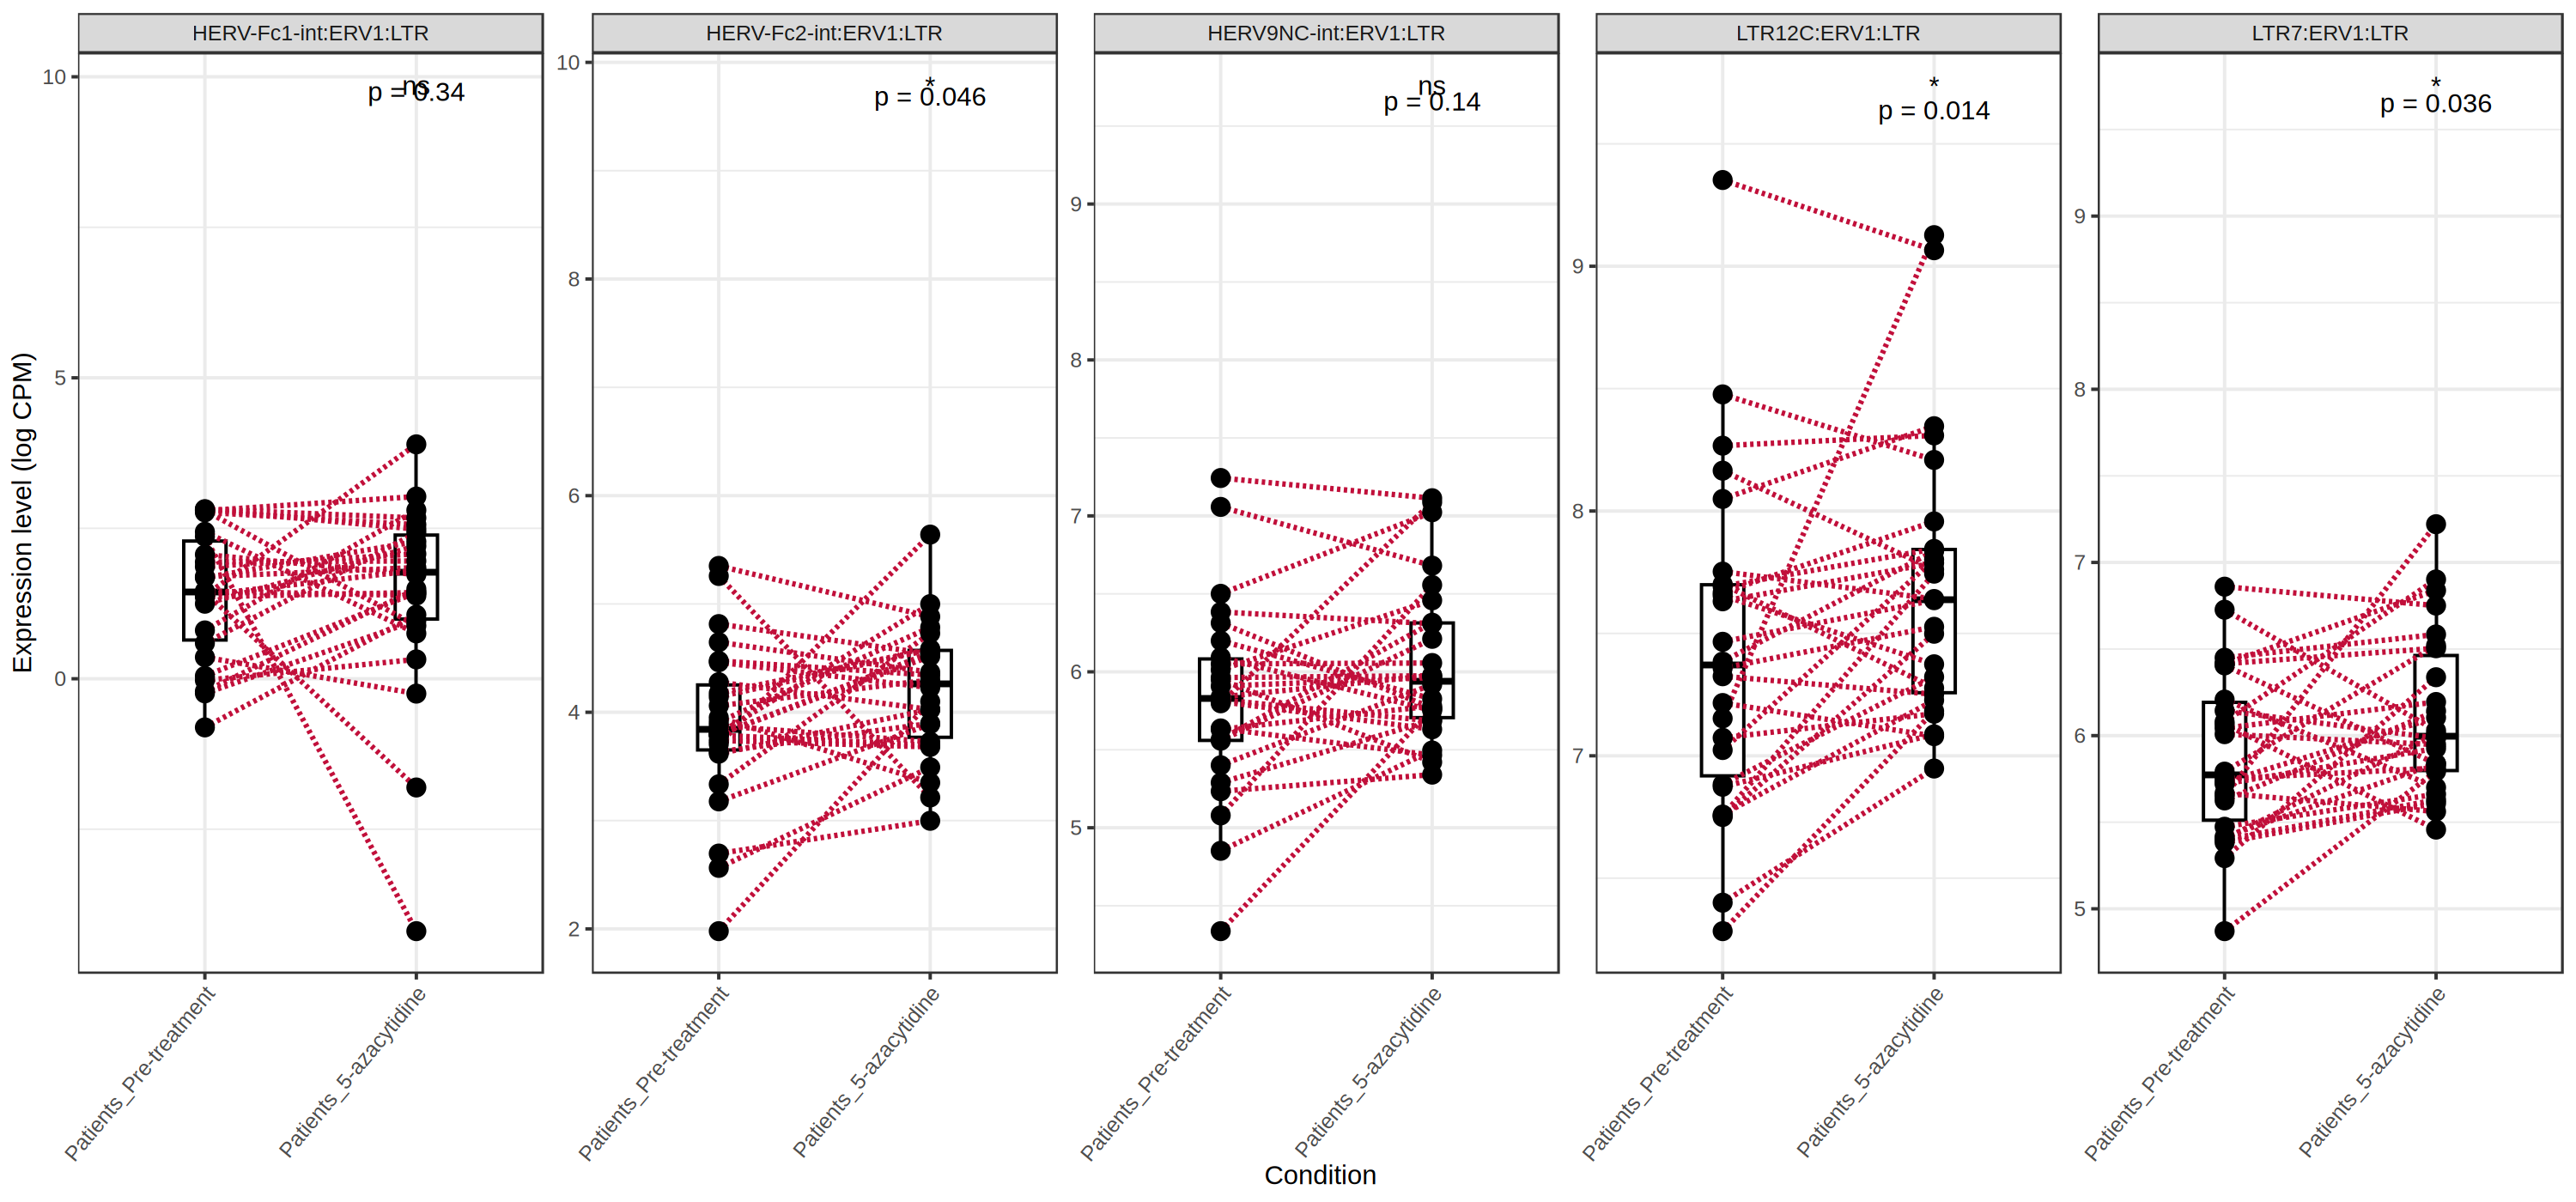

In [26]:
# Plot data

options(repr.plot.width = 15, repr.plot.height = 7, repr.plot.res = 200)

ggpaired(formatted_data,
         cond1 = 'Patients_Pre-treatment', cond2 = 'Patients_5-azacytidine', 
         id = 'patient_id', # Connect points by patient ID
         width = 0.2, 
         point.size = 3, 
         line.color = "#C10F3A",line.size = 0.8,
         linetype = 'dashed', 
         palette = "npg") + 
  stat_compare_means(paired = T, label = "p.signif", label.y = 9.7, ref.group = "Patients_Pre-treatment") + 
  stat_compare_means(paired = T, 
                     label = "p.format", 
                     label.y = 9.6, ref.group = "Patients_Pre-treatment") +
  facet_wrap(~ gene, ncol = 5, scale = 'free') +
  ylab('Expression level (log CPM)') +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 50, hjust = 1))


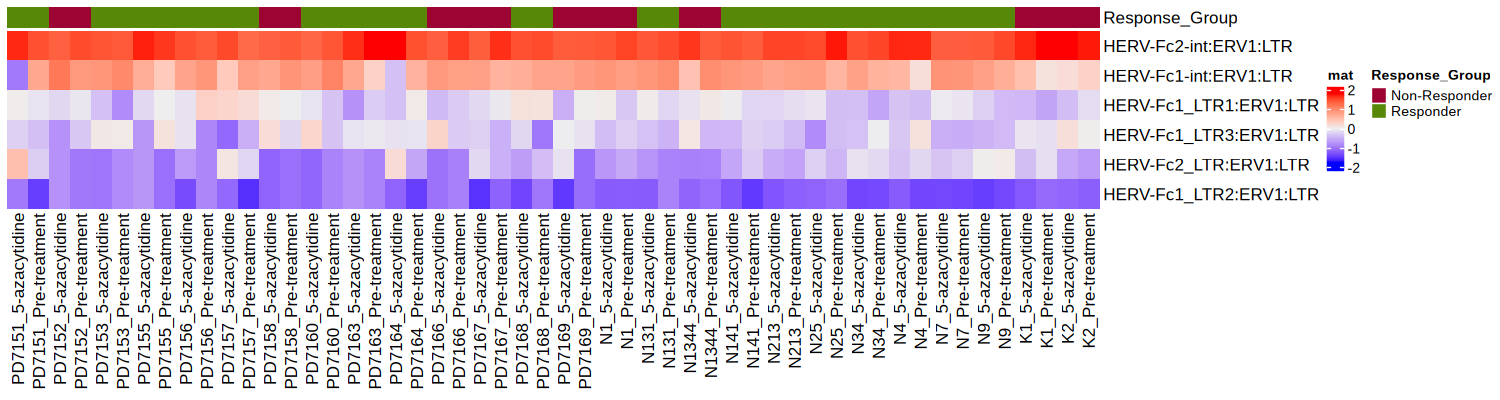

In [27]:
options(repr.plot.width = 15, repr.plot.height = 4, repr.plot.res = 100)

#List of genes to filter

genes_to_plot = c("HERV-Fc1-int:ERV1:LTR", "HERV-Fc1_LTR1:ERV1:LTR", "HERV-Fc1_LTR2:ERV1:LTR", 
"HERV-Fc1_LTR3:ERV1:LTR", "HERV-Fc2-int:ERV1:LTR", "HERV-Fc2_LTR:ERV1:LTR")

#genes_to_plot = c("LTR12:ERV1:LTR", "LTR12C:ERV1:LTR", "LTR12D:ERV1:LTR", "LTR12B:ERV1:LTR", "LTR12E:ERV1:LTR", "HERV9N-int:ERV1:LTR", 
#"HERV9NC-int:ERV1:LTR", "LTR7:ERV1:LTR", "LTR7B:ERV1:LTR","LTR7C:ERV1:LTR", "LTR7Y:ERV1:LTR")

# Extract the gene names from the first column of count_matrix
gene_names = Australian_count[, 1]


# Match the gene names with genes_to_plot
matching_rows = gene_names %in% genes_to_plot

# Filter the logcpm_mtx matrix for these specific genes based on matching_rows
filtered_mtx = logcpm_mtx[rownames(count_matrix) %in% genes_to_plot, ]

# Set the rownames of the filtered_mtx to the corresponding gene names
rownames(filtered_mtx) = gene_names[matching_rows]

# Scale the data (if required)
#plotdat = filtered_mtx
plotdat = scale(filtered_mtx)
plotdat[plotdat > 2] <- 2
plotdat[plotdat < -2] <- -2

# Plot the heatmap with annotations
column_ha = HeatmapAnnotation(df = dsn_df[, 'Response_Group', drop = F])
Heatmap(plotdat, name = "mat", show_column_names = TRUE, show_row_names = TRUE, 
        show_column_dend = FALSE, cluster_columns = FALSE, cluster_rows = TRUE,  
        show_row_dend = FALSE, top_annotation = column_ha)


In [ ]:
plotdat = scale_fun(filtered_mtx)
plotdat[plotdat > 2] <- 2
plotdat[plotdat < -2] <- -2

# Plot the heatmap with annotations
column_ha = HeatmapAnnotation(df = dsn_df[, 'Response_Group', drop = F])
Heatmap(plotdat, name = "mat", show_column_names = TRUE, show_row_names = TRUE, 
        show_column_dend = FALSE, cluster_columns = T, cluster_rows = TRUE,  
        show_row_dend = FALSE, top_annotation = column_ha)


In [37]:
head(filtered_mtx)

,PD7151_5-azacytidine,PD7151_Pre-treatment,PD7152_5-azacytidine,PD7152_Pre-treatment,PD7153_5-azacytidine,PD7153_Pre-treatment,PD7155_5-azacytidine,PD7155_Pre-treatment,PD7156_5-azacytidine,PD7156_Pre-treatment,⋯,N4_5-azacytidine,N4_Pre-treatment,N7_5-azacytidine,N7_Pre-treatment,N9_5-azacytidine,N9_Pre-treatment,K1_5-azacytidine,K1_Pre-treatment,K2_5-azacytidine,K2_Pre-treatment
HERV-Fc1-int:ERV1:LTR,-4.1930971,2.3627894,3.894252,1.380385,1.381418,1.455956,1.432132,0.04641774,1.7309487,2.06341727,⋯,0.9680945,-0.2423557,2.6723091,2.8176605,2.205136109,1.2465056,1.0626596,-0.808021,-0.2469647,0.3578946
HERV-Fc1_LTR1:ERV1:LTR,-0.9918878,-0.0698703,-1.748888,-1.421752,-2.348362,-4.193097,-1.954344,-1.07757420,-0.6839471,-0.01131331,⋯,-1.5042683,-1.7071963,-0.1650284,-0.1897472,-0.783757191,-1.6388785,-1.7488010,-2.857512,-2.0182071,-0.9703843
HERV-Fc1_LTR2:ERV1:LTR,-4.1930971,-4.1930971,-4.193097,-4.193097,-4.193097,-4.193097,-4.193097,-4.19309709,-4.1930971,-4.19309709,⋯,-3.8376530,-4.1930971,-4.1930971,-4.1930971,-4.193097093,-4.1930971,-4.1930971,-4.193097,-4.1930971,-4.1930971
HERV-Fc1_LTR3:ERV1:LTR,-1.8429828,-0.9893719,-4.193097,-2.224556,-1.059597,-1.500560,-4.193097,-0.70476358,-0.6839471,-4.19309709,⋯,-1.4134242,-0.3050339,-1.6529193,-1.5826399,-1.441672225,-1.6388785,-0.6288606,-1.495856,-0.3143225,-0.4725432
HERV-Fc2-int:ERV1:LTR,4.3694333,4.6467667,4.729361,3.334884,2.998157,2.695483,5.640383,3.70580760,3.7285494,3.87577604,⋯,4.0246226,3.6175898,4.0255900,4.2777637,3.897212625,3.6342777,4.7837443,3.910062,4.5387198,4.8141804
HERV-Fc2_LTR:ERV1:LTR,0.4845170,-0.6140222,-4.193097,-4.193097,-4.193097,-4.193097,-4.193097,-4.19309709,-2.3465344,-4.19309709,⋯,-1.5042683,-1.1519483,-1.0999313,-0.7058753,-0.007115141,-0.3695078,-1.6086335,-1.495856,-2.5565035,-2.6453732
